# Infectious Pulse
https://github.com/alvason/infectious-pulse/

### Many-strain SIR evolution --- its equilibrium state and infectious pulse due to mutation and cross-immunity

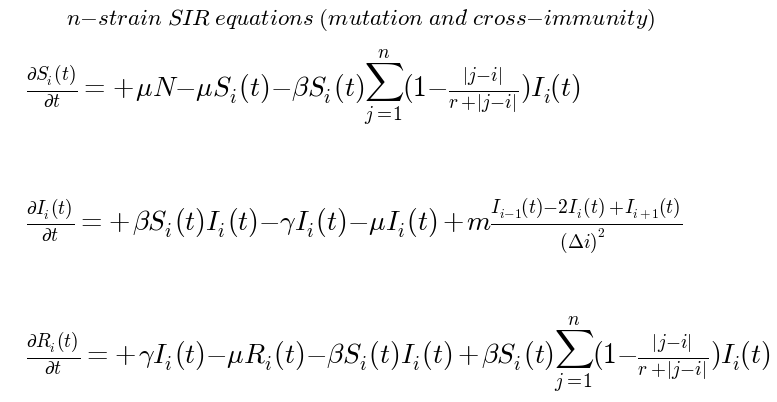

In [1]:
'''
author: Alvason Zhenhua Li
date:   03/23/2015
'''
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import time

import alva_machinery_event as alva

AlvaFontSize = 23
AlvaFigSize = (9, 7)
numberingFig = 0

numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize=(12, 6))
plt.axis('off')
plt.title(r'$ n-strain \ SIR \ equations \ (mutation \ and \ cross-immunity) $',fontsize = AlvaFontSize)
plt.text(0, 4.0/5,r'$ \frac{\partial S_i(t)}{\partial t} = \
        + \mu N - \mu S_i(t) - \beta S_i(t)\sum_{j = 1}^{n} (1 - \frac{|j - i|}{r + |j - i|})I_{i}(t) $'
         , fontsize = 1.2*AlvaFontSize)
plt.text(0, 2.0/5, r'$ \frac{\partial I_i(t)}{\partial t} = \
         + \beta S_i(t)I_i(t) - \gamma I_i(t) - \mu I_i(t) \
         + m \frac{I_{i - 1}(t) - 2I_i(t) + I_{i + 1}(t)}{(\Delta i)^2} $'
         , fontsize = 1.2*AlvaFontSize)
plt.text(0, 0.0/5,r'$ \frac{\partial R_i(t)}{\partial t} = \
         +\gamma I_i(t) - \mu R_i(t) - \beta S_i(t)I_i(t)\
         + \beta S_i(t)\sum_{j = 1}^{n} (1 - \frac{|j - i|}{r + |j - i|})I_{i}(t) $'
         , fontsize = 1.2*AlvaFontSize)
plt.show()

# define many-strain S-I-R equation
def dSdt_array(SIRxt = [], *args):
    # naming
    S = SIRxt[0]
    I = SIRxt[1]
    R = SIRxt[2]
    x_totalPoint = SIRxt.shape[1]
    # there are n dRdt
    dS_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    dS_dt_array[:] = - infecRate*S[:]*crossI_neighborSum_X(I, alva.eventName, gX)[:] \
                     + inOutRate*totalSIR - inOutRate*S[:]
    return(dS_dt_array)

def dIdt_array(SIRxt = [], *args):
    # naming
    S = SIRxt[0]
    I = SIRxt[1]
    R = SIRxt[2]
    x_totalPoint = SIRxt.shape[1]
    # there are n dRdt
    dI_dt_array = np.zeros(x_totalPoint)
    # each dIdt with the same equation form
    Icopy = np.copy(I)
    centerX = Icopy[:]
    leftX = np.roll(Icopy[:], 1)
    rightX = np.roll(Icopy[:], -1)
    leftX[0] =centerX[0]
    rightX[-1] = centerX[-1]
    dI_dt_array[:] = + infecRate*S[:]*I[:] \
                     - recovRate*I[:] - inOutRate*I[:] \
                     + mutatRate*(leftX[:] - 2*centerX[:] + rightX[:])/(dx**2)                                                                                             
    return(dI_dt_array)

def dRdt_array(SIRxt = [], *args):
    # naming
    S = SIRxt[0]
    I = SIRxt[1]
    R = SIRxt[2]
    x_totalPoint = SIRxt.shape[1]
    # there are n dRdt
    dR_dt_array = np.zeros(x_totalPoint)
    # each dIdt with the same equation form
    dR_dt_array[:] = + recovRate*I[:] - inOutRate*R[:] \
                     - infecRate*S[:]*I[:] \
                     + infecRate*S[:]*crossI_neighborSum_X(I, alva.eventName, gX)[:]
    return(dR_dt_array)

# inverted-monod equation
def monodInvert(half_radius, i):
    if half_radius == 0:
        gOut = i*0
        # numpy.reshape will not change the structure of i, 
        # so that the first element of i(unkonwn-size-array) can be setted by array_to_list[0] 
        array_to_list = np.reshape(i,[i.size,1]) 
        array_to_list[0] = 1 
    else: gOut = 1 - np.absolute(i)/(half_radius + np.absolute(i))
    return (gOut)

# cross immunity
def crossI_neighborSum_X(gI, half_radius, gX):
    total_neighbor_X = gX.shape[0]
    I_neighborSum = np.zeros(total_neighbor_X)
    # all I[xn] with neighbor-sum 
    ratioM = np.zeros([total_neighbor_X, total_neighbor_X])
    gXX = np.tile(gX, [total_neighbor_X, 1])
    gII = np.tile(gI, [total_neighbor_X, 1])
    ratioM[:, :] = monodInvert(half_radius, gXX[:, :] - gXX[:, :].T)
    I_neighborSum[:] = np.sum(ratioM[:, :] * gII[:, :].T, axis = 0)
    if half_radius == 0:
        I_neighborSum = np.copy(gI)
    return (I_neighborSum)

('machinery running time =', 21.854768991470337)


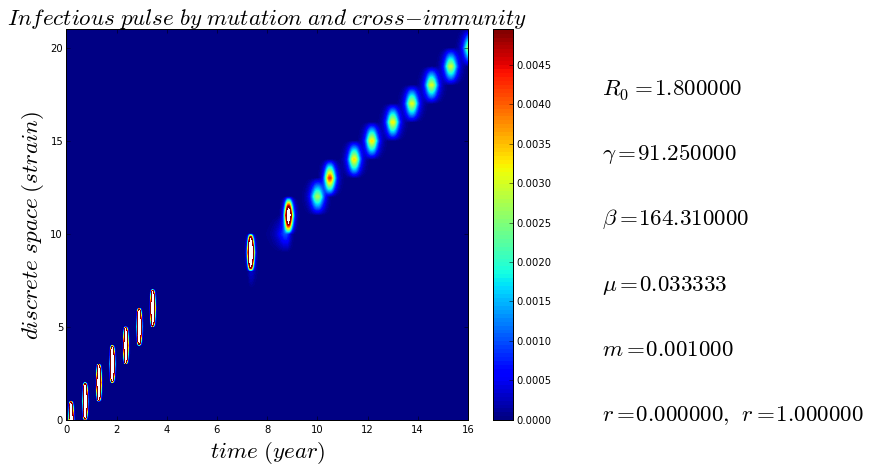

In [2]:
# setting parameter
timeUnit = 'year'
if timeUnit == 'day':
    day = 1
    year = 365
elif timeUnit == 'year':
    year = 1
    day = float(1)/365 
    
totalSIR = float(1) # total population
reprodNum = 1.8 # basic reproductive number R0: one infected person will transmit to 1.8 person 
recovRate = float(1)/(4*day) # 4 days per period ==> rate/year = 365/4
inOutRate = float(1)/(30*year) # birth rate per year
infecRate = reprodNum*(recovRate + inOutRate)/totalSIR # per year, per person, per total-population
mutatRate = float(1)/(10**17) # mutation rate
#cross_radius = float(1) # radius of cross-immunity (the distance of half-of-value in the Monod equation) 

# time boundary and griding condition
minT = float(0)*year
maxT = float(16)*year
totalPoint_T = int(2*10**3 + 1)
spacingT = np.linspace(minT, maxT, num = totalPoint_T, retstep = True)
gT = spacingT[0]
dt = spacingT[1]

# space boundary and griding condition
minX = float(0)
maxX = float(21)
totalPoint_X = int(maxX*1 + 1)
gridingX = np.linspace(minX, maxX, num = totalPoint_X, retstep = True)
gX = gridingX[0]
dx = gridingX[1]

gS_array = np.zeros([totalPoint_X, totalPoint_T])
gI_array = np.zeros([totalPoint_X, totalPoint_T])
gR_array = np.zeros([totalPoint_X, totalPoint_T])

# initial output condition (only one virus in equilibrium condition)
# for fast switching from one-virus equilibrium to many-virus equilibrium, invert-Monod distribution of S and R are applied 
#gI_array[0, 0] = inOutRate*totalSIR*(reprodNum - 1)/infecRate  # only one virus exists
#gR_array[:, 0] = recovRate*totalSIR*(reprodNum - 1)/infecRate * monodInvert(cross_radius, gX)
#gS_array[:, 0] = totalSIR - gI_array[:, 0] - gR_array[:, 0]

gI_array[0, 0] = float(1)/10**6  # only one virus exists
gR_array[0, 0] = float(0)
gS_array[:, 0] = totalSIR - gI_array[:, 0] - gR_array[:, 0]

event_tn_In = np.array([[0, 0], [3, 1]]) # cross_radius 
# Runge Kutta numerical solution
time_start = time.time()
pde_array = np.array([dSdt_array, dIdt_array, dRdt_array])
initial_Out = np.array([gS_array, gI_array, gR_array])
gOut_array = alva.AlvaRungeKutta4XT(pde_array, initial_Out, minX, maxX, totalPoint_X, minT, maxT, totalPoint_T, event_tn_In)
time_stop = time.time()
print ('machinery running time =', time_stop - time_start)
# plotting
gS = gOut_array[0]  
gI = gOut_array[1]
gR = gOut_array[2]

numberingFig = numberingFig + 1
maxLevel = gI_array[0, 0]*5000
plt.figure(numberingFig, figsize = AlvaFigSize)
plt.contourf(gT, gX, gI, levels = np.arange(0, maxLevel, maxLevel/100))
plt.title(r'$ Infectious \ pulse \ by \ mutation \ and \ cross-immunity $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ discrete \ space \ (strain) $', fontsize = AlvaFontSize)
plt.colorbar()
plt.text(maxT*4.0/3, maxX*5.0/6, r'$ R_0 = %f $'%(reprodNum), fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*4.0/6, r'$ \gamma = %f $'%(recovRate), fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*3.0/6, r'$ \beta = %f $'%(infecRate), fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*2.0/6, r'$ \mu = %f $'%(inOutRate), fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*1.0/6, r'$ m = %f $'%(mutatRate*10**14), fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*0.0/6, r'$ r = %f, \ \ r = %f $'%(event_tn_In[0, 1], event_tn_In[1, 1]), fontsize = AlvaFontSize)
plt.show()

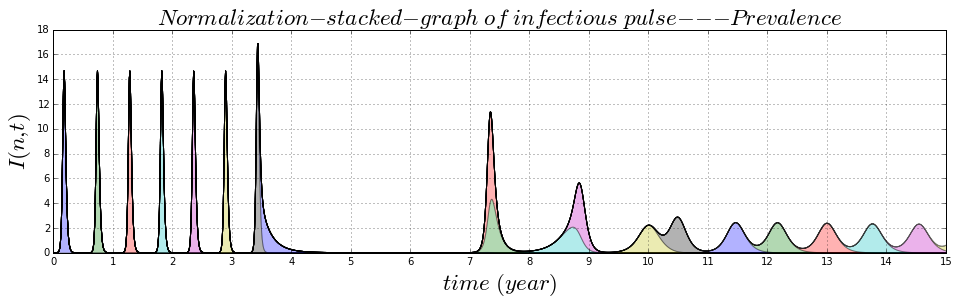

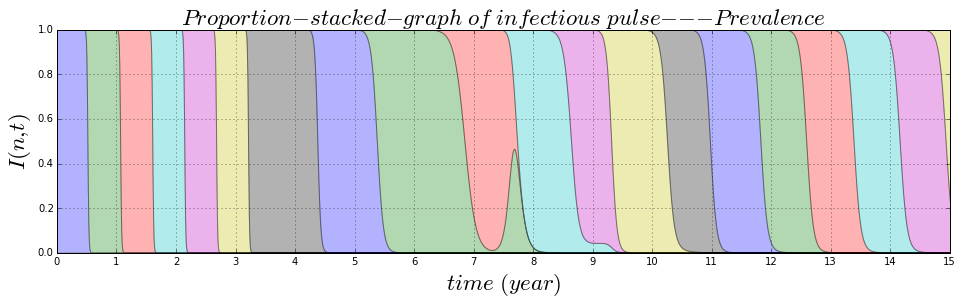

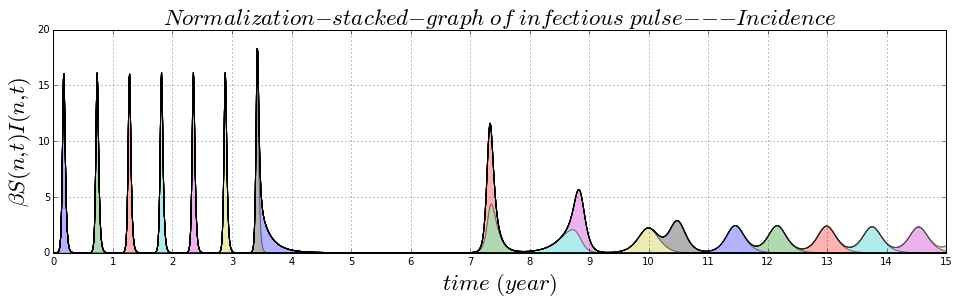

In [3]:
# Normalization stacked graph
cutting_X = -1
cutting_T = -1
gI_N = np.copy(gI)
for xn in range(totalPoint_X):
    gI_N[xn, :] = gI_N[xn, :]/np.sum(gI_N[xn, :]*dt)
numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize = (16, 4))
plt.stackplot(gT[:cutting_T], gI_N[:cutting_X, :cutting_T], alpha = 0.3)
plt.title(r'$ Normalization-stacked-graph \ of \ infectious \ pulse---Prevalence $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ I(n,t) $', fontsize = AlvaFontSize)
plt.xlim(minT, maxT - 1)
#plt.ylim(0, 4)
plt.axes().set_xticks(np.arange(minT, maxT))
plt.grid(True)
plt.show()

# Proportion stacked graph
gI_P = np.copy(gI)
for tn in range(totalPoint_T):
    gI_P[:, tn] = gI_P[:, tn]/np.sum(gI_P[:, tn])
numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize = (16, 4))
plt.stackplot(gT[:cutting_T], gI_P[:cutting_X, :cutting_T], alpha = 0.3)
plt.title(r'$ Proportion-stacked-graph \ of \ infectious \ pulse---Prevalence $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ I(n,t) $', fontsize = AlvaFontSize)
plt.xlim(minT, maxT - 1)
plt.ylim(0, 1)
plt.axes().set_xticks(np.arange(minT, maxT))
plt.grid(True)
plt.show()

# Normalization stacked graph of Incidence
gInc = np.zeros([totalPoint_X, totalPoint_T])
for xn in range(totalPoint_X):
    gInc[xn, :] = infecRate*gS[xn, :]*gI[xn, :]/np.sum(infecRate*gS[xn, :]*gI[xn, :]*dt)
numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize = (16, 4))
plt.stackplot(gT[:cutting_T], gInc[:cutting_X, :cutting_T], alpha = 0.3)
plt.title(r'$ Normalization-stacked-graph \ of \ infectious \ pulse---Incidence $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ \beta S(n,t)I(n,t) $', fontsize = AlvaFontSize)
plt.xlim(minT, maxT - 1)
#plt.ylim(0, 4)
plt.axes().set_xticks(np.arange(minT, maxT))
plt.grid(True)
plt.show()

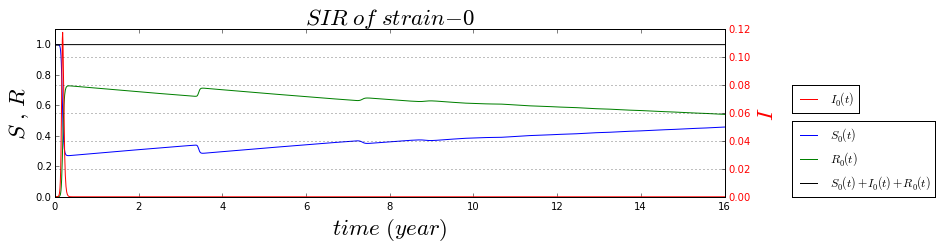

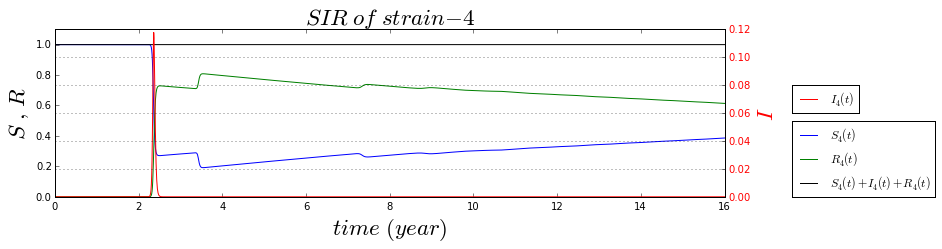

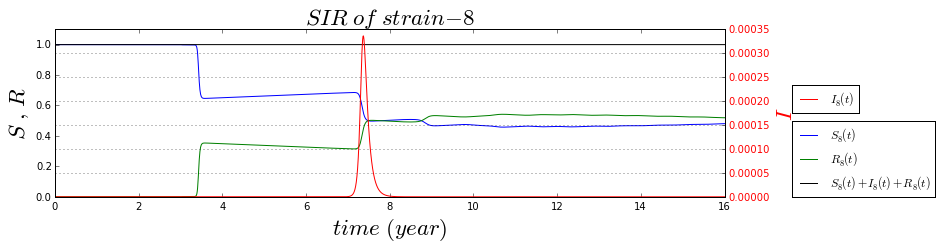

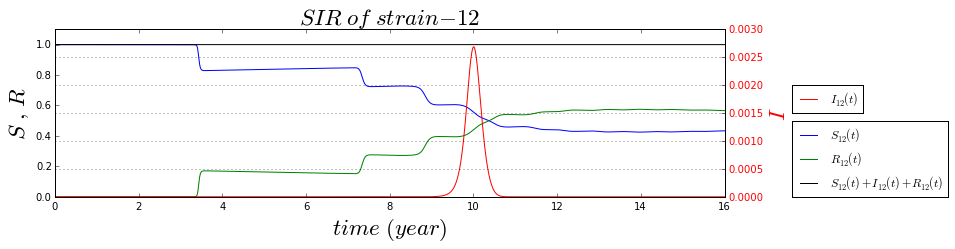

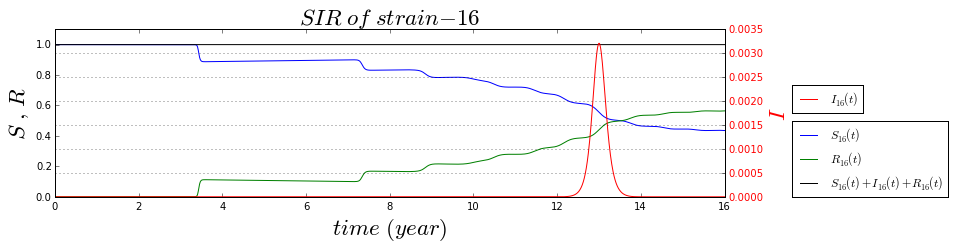

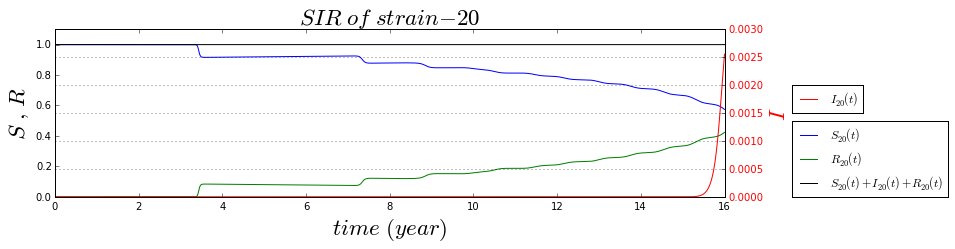

In [4]:
# plot by listing each strain 
numberingFig = numberingFig + 1
for i in range(0, totalPoint_X, 4):
    figure = plt.figure(numberingFig, figsize = (12, 3))
    plot1 = figure.add_subplot(1, 1, 1)
    plot1.plot(gT, gS[i], label = r'$ S_{%i}(t) $'%(i), color = 'blue')
    plot1.plot(gT, gR[i], label = r'$ R_{%i}(t) $'%(i), color = 'green')
    plot1.plot(gT, (gS[i] + gI[i] + gR[i]).T, label = r'$ S_{%i}(t)+I_{%i}(t)+R_{%i}(t) $'%(i, i, i), color = 'black')    
    plot1.set_xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
    plot1.set_ylabel(r'$ S \ , \ R $', fontsize = AlvaFontSize)
    plot1.set_ylim(0, totalSIR*1.1)
    plot1.legend(loc = (1.1, 0))
    
    plot2 = plot1.twinx()
    plot2.plot(gT, gI[i], label = r'$ I_{%i}(t) $'%(i), color = 'red')
    plot2.set_ylabel(r'$ I $', fontsize = AlvaFontSize, color = 'red')
    for tl in plot2.get_yticklabels(): tl.set_color('red')
    plot2.legend(loc = (1.1, 0.5))
    
    plt.grid(True)
    plt.title(r'$ SIR \ of \ strain-%i $'%(i), fontsize = AlvaFontSize)
    plt.show()


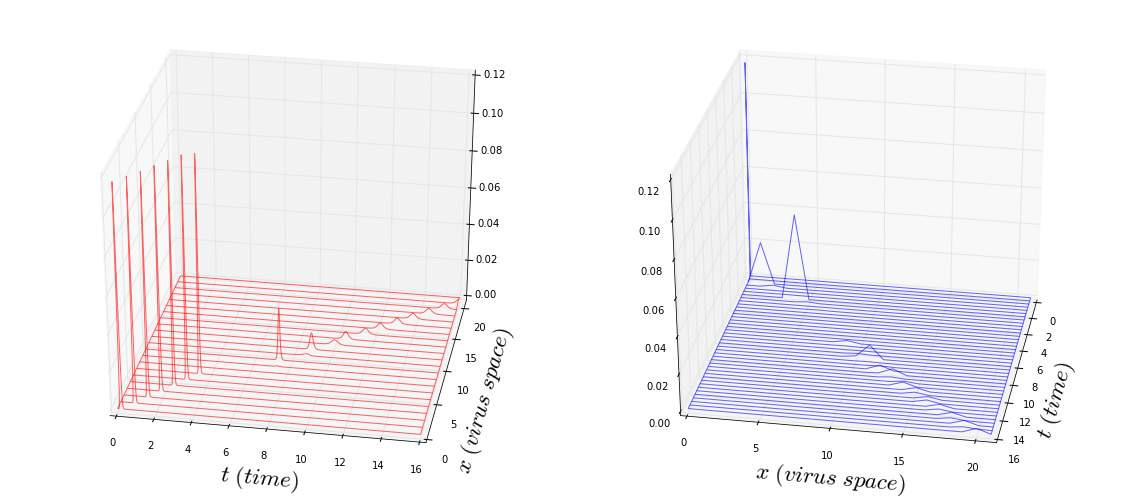

In [5]:
# 3D plotting
# define GridXX function for making 2D-grid from 1D-grid
def AlvaGridXX(gX, totalPoint_Y):
    gXX = gX;
    for n in range(totalPoint_Y - 1):
        gXX = np.vstack((gXX, gX))
    return (gXX)
# for 3D plotting
X = AlvaGridXX(gT, totalPoint_X)
Y = AlvaGridXX(gX, totalPoint_T).T 
Z = gI
numberingFig = numberingFig + 1
figure = plt.figure(numberingFig, figsize=(16, 7))

plot1 = figure.add_subplot(1, 2, 1, projection = '3d')
plot1.view_init(30, -80)
plot1.plot_wireframe(X, Y, Z, cstride = totalPoint_T, rstride = int(dx), alpha = 0.6, color = 'red')
plt.xlabel(r'$t \ (time)$', fontsize = AlvaFontSize)
plt.ylabel(r'$x \ (virus \ space)$', fontsize = AlvaFontSize)
plt.xlim(minT, maxT)
plt.ylim(minX, maxX)

plot2 = figure.add_subplot(1, 2, 2, projection = '3d')
plot2.view_init(30, 10)
plot2.plot_wireframe(X, Y, Z, cstride = totalPoint_T/40, rstride = int(maxX), alpha = 0.6)
plt.xlabel(r'$t \ (time)$', fontsize = AlvaFontSize)
plt.ylabel(r'$x \ (virus \ space)$', fontsize = AlvaFontSize)
plt.xlim(minT, maxT)
plt.ylim(minX, maxX)

figure.tight_layout()
plt.show()

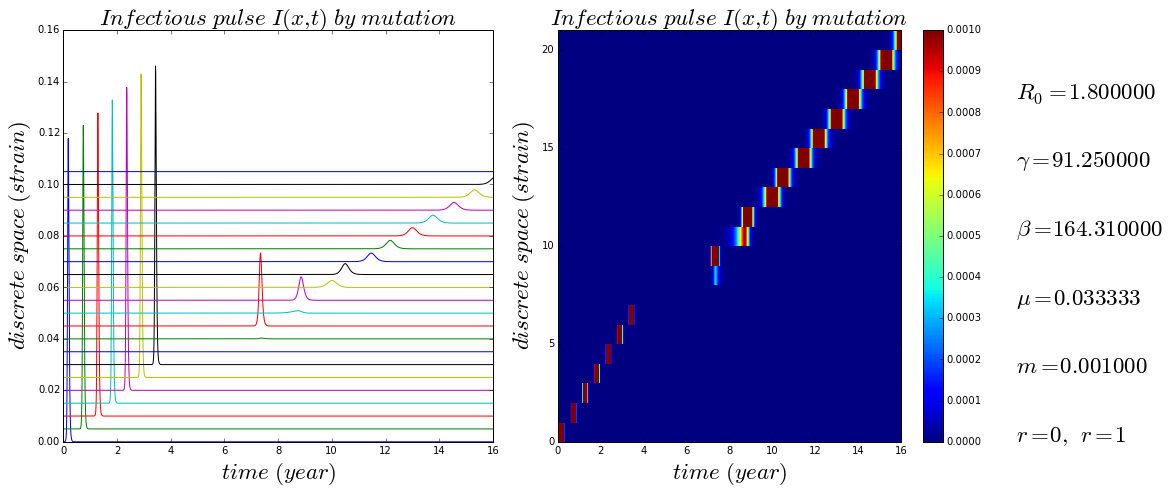

In [6]:
numberingFig = numberingFig + 1;
figure = plt.figure(numberingFig, figsize = (14, 7))
plot1 = figure.add_subplot(1, 2, 2)
#colorPlot = plot1.contourf(gT, gX, gI, levels = np.arange(0, 0.12, 0.001))
colorPlot = plot1.pcolor(gT, gX, gI, vmin = 0, vmax = 0.001)
plt.title(r'$ Infectious \ pulse \ I(x,t) \ by \ mutation $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ discrete \ space \ (strain) $', fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*5.0/6, r'$ R_0 = %f $'%(reprodNum), fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*4.0/6, r'$ \gamma = %f $'%(recovRate), fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*3.0/6, r'$ \beta = %f $'%(infecRate), fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*2.0/6, r'$ \mu = %f $'%(inOutRate), fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*1.0/6, r'$ m = %f $'%(mutatRate*10**14), fontsize = AlvaFontSize)
plt.text(maxT*4.0/3, maxX*0.0/6, r'$ r = %i, \ \ r = %i $'%(event_tn_In[0, 1], event_tn_In[1, 1]), fontsize = AlvaFontSize)
plt.colorbar(colorPlot)
plt.xlim(minT, maxT)
plt.ylim(minX, maxX)

plot2 = figure.add_subplot(1, 2, 1)
plot2.plot(gT, (gI.T + np.arange(totalPoint_X)*0.005))
plt.title(r'$ Infectious \ pulse \ I(x,t) \ by \ mutation  $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ discrete \ space \ (strain) $', fontsize = AlvaFontSize)
plt.xlim(minT, maxT)

figure.tight_layout()
plt.show()